This tutorial is composed of the [FEniCSs tutorial (legacy version)](https://github.com/hplgit/fenics-tutorial/) and the [FEniCSx tutorial](https://jsdokken.com/dolfinx-tutorial/chapter1/fundamentals.html). 

## Mathematical problem formulation

Many books on programming languages start with a "Hello, World!"
program. Readers are curious to know how fundamental tasks are
expressed in the language, and printing a text to the screen can be
such a task. In the world of *finite element methods for PDEs*, the
most fundamental task must be to solve the Poisson equation. Our
counterpart to the classical "Hello, World!" program therefore
solves the following boundary-value problem: We want to solve

$$\begin{align}
-\Delta u(x) &= f(x),\quad &&x\text{ in } \Omega,\tag{1}\\
u(x) &= u_D(x),\quad &&x\text{ on } \partial \Omega\tag{2}
\end{align}$$

where
$u = u(x)$ is the unknown function, $f = f(x)$ is a
prescribed function, $\Delta$ is the Laplace operator
(also written as $\nabla^2$), $\Omega$ is the spatial domain, and
$\partial\Omega$ is the boundary of $\Omega$. The Poisson problem,
including both the PDE $-\Delta u = f$ and the boundary condition
$u = u_D$ on $\partial \Omega$, is an example of a *boundary-value
problem*, which must be precisely stated before
it makes sense to start solving it with FEniCSx.

### Poisson's equation

In two space dimensions with coordinates $x$ and $y$, we can write out
the Poisson equation as

\begin{equation}
- {\partial^2 u\over\partial x^2} - {\partial^2 u\over\partial y^2} = f(x,y)\tag{3}
\end{equation}

The unknown $u$ is now a function of two variables, $u = u(x,y)$, defined
over a two-dimensional domain $\Omega$.

The Poisson equation arises in numerous physical contexts, including
heat conduction, electrostatics, diffusion of substances, twisting of
elastic rods, inviscid fluid flow, and water waves. Moreover, the
equation appears in numerical splitting strategies for more complicated
systems of PDEs, in particular the Navier-Stokes equations.

Solving a boundary-value problem such as the Poisson equation in
FEniCSx consists of the following steps:

1. Identify the computational domain ($\Omega$), the PDE, its boundary conditions, and source terms ($f$).
1. Reformulate the PDE as a finite element variational problem.
1. Write a Python program which defines the computational domain,
    the variational problem, the boundary conditions, and source
    terms, using the corresponding FEniCSx abstractions.
1. Call FEniCSx to solve the boundary-value problem and, optionally,
    extend the program
    to compute derived quantities such as fluxes and averages, and
    visualize the results.

We shall now go through steps 2-4 in detail. The key feature of
FEniCSx is that steps 3 and 4 result in fairly short code, while a
similar program in most other software frameworks for PDEs require
much more code and technically difficult programming.

**💡 What makes FEniCSx attractive?**
Although many software frameworks have a really elegant
"Hello, World!" example for the
Poisson equation, FEniCSx is to our knowledge the only framework where
the code stays compact and nice, very close to the mathematical
formulation, even when the mathematical and algorithmic complexity
increases and when moving from a laptop to a high-performance
compute server (cluster).

### Finite element variational formulation

FEniCSx is based on the finite element method, which is a general and
efficient mathematical machinery for the numerical solution of
PDEs. The starting point for the finite element methods is a PDE
expressed in *variational form*. Readers who are not familiar with
variational problems will get a very brief introduction to the topic
in this tutorial, but reading a proper book on the finite element
method in addition is encouraged. Experience shows that you can work with
FEniCSx as a tool to solve PDEs even without thorough knowledge of
the finite element method, as long as you get somebody to help you
with formulating the PDE as a variational problem.

The basic recipe for turning a PDE into a variational problem is to
multiply the PDE by a function $v$, integrate the resulting equation
over the domain $\Omega$, and perform integration by parts of terms
with second-order derivatives. The function $v$ which multiplies the
PDE is called a *test function*. The unknown function $u$ to be
approximated is referred to as a *trial function*. The terms trial and
test functions are used in FEniCS programs too. The trial and test
functions belong to certain so-called *function spaces* that specify
the properties of the functions.


In the present case, we first multiply the Poisson equation
by the test function $v$ and integrate over $\Omega$:

\begin{equation}
-\int_\Omega (\Delta u)v \;\text{d}x = \int_\Omega fv \;\text{d}x\tag{4}
\end{equation}

We here let $\text{d}x$ denote the differential element for integration over
the domain $\Omega$. We will later let $\text{d}s$ denote the differential
element for integration over the boundary of $\Omega$.

A common rule when we derive variational formulations is that we try
to keep the order of the derivatives of $u$ and $v$ as small as
possible. Here, we have a second-order spatial derivative of $u$,
which can be transformed to a first-derivative of $u$ and $v$ by
applying the technique of ["integration by parts"](https://en.wikipedia.org/wiki/Integration_by_parts").
The formula reads

\begin{equation}
-\int_\Omega (\Delta u)v \;\text{d}x
= \int_\Omega\nabla u\cdot\nabla v \;\text{d}x - \int_{\partial\Omega}{\partial u\over
\partial n}v \;\text{d}s ,\tag{5}
\end{equation}
where $\frac{\partial u}{\partial n} = \nabla u \cdot n$ is the
derivative of $u$ in the outward normal direction $n$ on the
boundary.

Another feature of variational formulations is that
the test function $v$ is required to vanish on the parts of
the boundary where the solution $u$ is known (the book cite{Langtangen_Mardal_FEM_2016} explains in detail why this requirement is necessary).
In the present
problem, this means that $v=0$ on the whole boundary $\partial\Omega$.
The second term on the right-hand side of
(5) therefore vanishes. From
(4) and (5) it
follows that

\begin{equation}
\int_\Omega\nabla u\cdot\nabla v \;\text{d}x = \int_\Omega fv \;\text{d}x\tag{6}
\end{equation}

If we require that this equation holds for all test functions $v$ in
some suitable space $\hat V$, the so-called *test space*, we obtain a
well-defined mathematical problem that uniquely determines the
solution $u$ which lies in some (possibly different) function space
$V$, the so-called *trial space*.  We refer to
(6) as the *weak form* or *variational form* of
the original boundary-value problem
(1)-(2).

The proper statement of
our variational problem now goes as follows:
find $u \in V$ such that

\begin{equation}\tag{7}
  \int_{\Omega} \nabla u \cdot \nabla v \;\text{d}x =
  \int_{\Omega} fv \;\text{d}x
  \quad \forall v \in \hat{V}
\end{equation}

The trial and test spaces $V$ and $\hat V$ are in the present
problem defined as

\begin{align*}
     V      &= \{v \in H^1(\Omega) : v = u_D \text{ on } \partial\Omega\}, \\
    \hat{V} &= \{v \in H^1(\Omega) : v = 0 \text{ on } \partial\Omega\}
\end{align*}

In short, $H^1(\Omega)$ is the mathematically well-known Sobolev space
containing functions $v$ such that $v^2$ and $|\nabla v|^2$ have
finite integrals over $\Omega$ (essentially meaning that the functions
are continuous). The solution of the underlying PDE must lie in a
function space where the derivatives are also continuous, but the
Sobolev space $H^1(\Omega)$ allows functions with discontinuous
derivatives. This weaker continuity requirement of $u$ in the
variational statement (7), as a result of the
integration by parts, has great practical consequences when it comes
to constructing finite element function spaces. In particular, it
allows the use of piecewise polynomial function spaces; i.e., function
spaces constructed by stitching together polynomial functions on simple
domains such as intervals, triangles, or tetrahedrons.

The variational problem (7) is a *continuous
problem*: it defines the solution $u$ in the infinite-dimensional
function space $V$. The finite element method for the Poisson equation
finds an approximate solution of the variational problem
(7) by replacing the infinite-dimensional function
spaces $V$ and $\hat{V}$ by *discrete* (finite-dimensional) trial and
test spaces $V_h\subset{V}$ and $\hat{V}_h\subset\hat{V}$. The discrete variational problem reads: find $u_h \in
V_h \subset V$ such that

\begin{equation}\tag{8}
  \int_{\Omega} \nabla u_h \cdot \nabla v \;\text{d}x =
  \int_{\Omega} fv \;\text{d}x
  \quad \forall v \in \hat{V}_h \subset \hat{V}
\end{equation}

This variational problem, together with a suitable definition of the
function spaces $V_h$ and $\hat{V}_h$, uniquely define our approximate
numerical solution of Poisson's equation (1). Note
that the boundary conditions are encoded as part of the trial and test
spaces. The mathematical framework may seem complicated at first
glance, but the good news is that the finite element variational
problem (8) looks the same as the continuous
variational problem (7), and FEniCSx can
automatically solve variational problems like (8)!

**💡 What we mean by the notation $u$ and $V$:**
The mathematics literature on variational problems writes $u_h$ for
the solution of the discrete problem and $u$ for the solution of the
continuous problem. To obtain (almost) a one-to-one relationship
between the mathematical formulation of a problem and the
corresponding FEniCSx program, we shall drop the subscript $_h$ and use
$u$ for the solution of the discrete problem.
We will use $u_e$ for the exact
solution of the continuous problem, if we need to explicitly distinguish
between the two. Similarly, we will let $V$ denote the discrete finite
element function space in which we seek our solution.

### Abstract finite element variational formulation

It turns out to be convenient to introduce the following canonical
notation for variational problems: find $u\in V$ such that

\begin{equation}\tag{9}
a(u, v) = L(v) \quad \forall v \in \hat{V}.
\end{equation}

For the Poisson equation, we have:

\begin{align}
a(u, v) &= \int_{\Omega} \nabla u \cdot \nabla v \;\text{d}x,\tag{10}\\
L(v) &= \int_{\Omega} fv \;\text{d}x\tag{11}
\end{align}

From the mathematics literature, $a(u,v)$ is known as a *bilinear
form* and $L(v)$ as a *linear form*.  We shall, in every linear problem
we solve, identify the terms with the unknown $u$ and collect them in
$a(u,v)$, and similarly collect all terms with only known functions in
$L(v)$. The formulas for $a$ and $L$ can then be expressed directly in
our FEniCSx programs.

To solve a linear PDE in FEniCSx, such as the Poisson equation, a user
thus needs to perform only two steps:

  * Choose the finite element spaces $V$ and $\hat V$ by specifying
    the domain (the mesh) and the type of function space (polynomial
    degree and type).
  * Express the PDE as a (discrete) variational problem: find $u\in V$
    such that $a(u,v) = L(v)$ for all $v\in \hat{V}$.

### Choosing a test problem

The Poisson problem (1)-(2) has so
far featured a general domain $\Omega$ and general functions $u_D$ for
the boundary conditions and $f$ for the right-hand side. For our first
implementation we will need to make specific choices for $\Omega$,
$u_D$, and $f$. It will be wise to construct a problem with a known
analytical solution so that we can easily check that the computed
solution is correct. Solutions that are lower-order polynomials are
primary candidates. Standard finite element function spaces of degree
$r$ will exactly reproduce polynomials of degree $r$. And piecewise
linear elements ($r=1$) are able to exactly reproduce a quadratic
polynomial on a uniformly partitioned mesh. This important result can
be used to verify our implementation. We just manufacture some
quadratic function in 2D as the exact solution, say

\begin{equation}
u_e(x,y) = 1 +x^2 + 2y^2\tag{12}
\end{equation}

By inserting (12) into the Poisson equation
(1), we find that $u_e(x,y)$ is a solution if

\begin{equation}
f(x,y) = -6,\quad u_D(x,y)=u_e(x,y)=1 + x^2 + 2y^2,
\end{equation}

regardless of the shape of the domain as long as $u_e$ is prescribed along
the boundary. We choose here, for simplicity,
the domain to be the unit square,

\begin{equation}
\Omega = ]0,1[\times ]0,1[
\end{equation}

This simple but very powerful method for constructing test problems is
called the *method of manufactured solutions*: pick a simple
expression for the exact solution, plug it into the equation to obtain
the right-hand side (source term $f$), then solve the equation with
this right-hand side and using the exact solution as a boundary
condition, and try to reproduce the exact solution.

**💡 Tip:**
Try to verify your code with exact numerical solutions!
A common approach to testing the implementation of a numerical method
is to compare the numerical
solution with an exact analytical solution of the test problem and
conclude that the program works if the error is "small enough".
Unfortunately, it is impossible to tell if an error of size $10^{-5}$ on a
$20\times 20$ mesh of linear elements is the expected (in)accuracy of the
numerical approximation or if the error also contains the effect of a
bug in the code. All we usually know about the numerical error is its
*asymptotic properties*, for instance that it is proportional to $h^2$
if $h$ is the size of a cell in the mesh. Then we compare the
error on meshes with different $h$-values to see if the asymptotic
behavior is correct. This is a very powerful verification
technique and is explained in detail later on.

## FEniCSx implementation

### The complete program

A FEniCSx program for solving our test problem for the Poisson equation
in 2D with the given choices of $\Omega$, $u_D$, and $f$ may look as
follows:

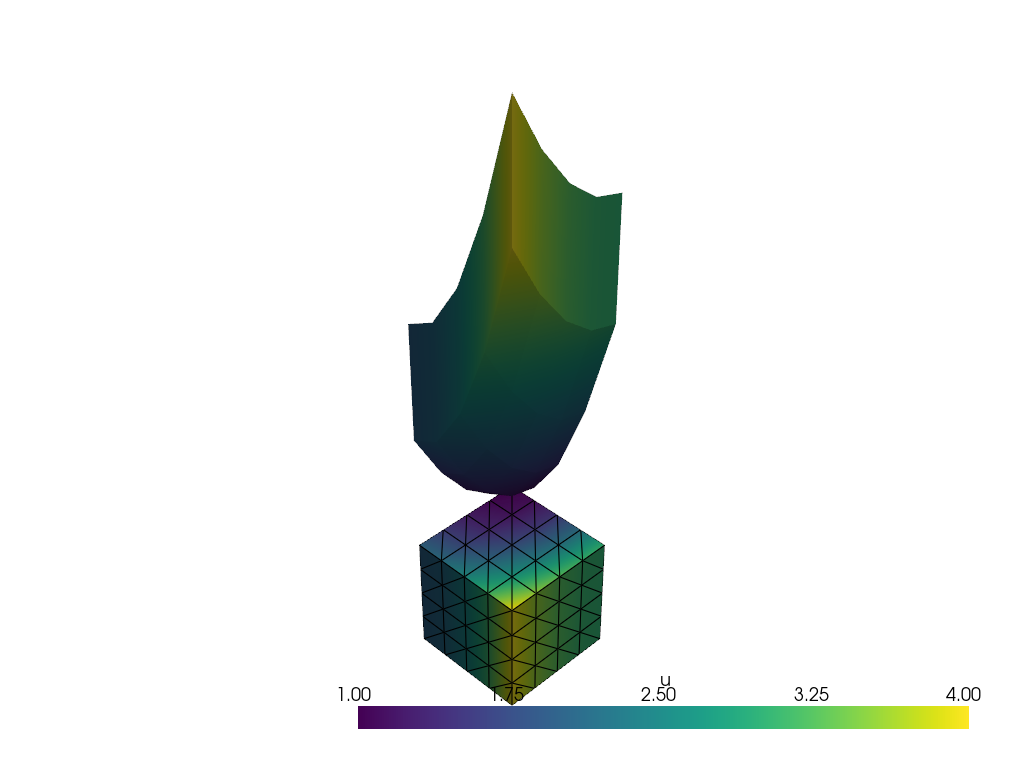

In [5]:
from mpi4py import MPI
import numpy as np
from dolfinx import mesh, fem, plot, io
from dolfinx.fem.petsc import LinearProblem
from ufl import SpatialCoordinate, TrialFunction, TestFunction, inner, grad, dx

# Create mesh and define function space
# msh = mesh.create_unit_square(
#     comm=MPI.COMM_WORLD,
#     nx=4,
#     ny=4
# )

msh = mesh.create_unit_cube(
    comm=MPI.COMM_WORLD,
    nx=4,
    ny=4,
    nz=4
)


V = fem.functionspace(
    mesh=msh,
    element=("P", 1)
)

# Define boundary condition
def on_boundary(x):
    return np.isclose(x[0], 0) | np.isclose(x[0], 1) | np.isclose(x[1], 0) | np.isclose(x[1], 1)| np.isclose(x[2], 0) | np.isclose(x[2], 1)

boundary_dofs = fem.locate_dofs_geometrical(V=V, marker=on_boundary)

def manufactured_solution(x):
    return 1 + x[0]**2 + 2 * x[1]**2

uD = fem.Function(V)
uD.interpolate(manufactured_solution)

bc = fem.dirichletbc(value=uD, dofs=boundary_dofs)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = fem.Constant(msh, -6.)
a = inner(grad(u), grad(v)) * dx
L = f * v * dx

# Compute solution
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()
uh.name = "Solution u"

# Plot solution and mesh
import pyvista

cells, types, x = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(cells, types, x)
grid.point_data["u"] = uh.x.array.real
grid.set_active_scalars("u")
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
warped = grid.warp_by_scalar()
plotter.add_mesh(warped)
plotter.show()

# Save solution to file in VTX format
with io.VTXWriter(msh.comm, "results/poisson.bp", [uh]) as vtx:
    vtx.write(0.0)

### Running the program

The FEniCSx program must be available in a plain text file, written with a
text editor such as Nano, Vim, VS Code, VSCodium or similar.
There are several ways to run a Python program like `poisson.py`:

 * Use a terminal window.
 * Use an integrated development environment (IDE), e.g. Spyder, VS Code or VSCodium.
 * Use a Jupyter notebook.

 ```
 python poisson.py
 ```

 ⚠️ Note that this command must be run in a FEniCSx-enabled terminal. For users of FEniCSx in Conda, this means that you must type
this command after you have started a FEniCS session using `conda activate fenicsx-env`, or by selecting the FEniCSx Conda environment in your IDE or Jupyter notebook, respectively.

## Dissection of the program

We shall now dissect our FEniCSx program in detail.  The listed FEniCSx
program defines a finite element mesh, a finite element function space
$V$ on this mesh, boundary conditions for $u$ (the function $u_D$),
and the bilinear and linear forms $a(u,v)$ and $L(v)$. Thereafter, the
solution $u$ is computed. At the end of the program, we compare the
numerical and the exact solutions. We also save the solution to a file for external
postprocessing.

### The important first lines

The first lines in the program,

```python
from mpi4py import MPI
import numpy as np
from dolfinx import mesh, fem, plot, io
from dolfinx.fem.petsc import LinearProblem
from ufl import TrialFunction, TestFunction, inner, grad, dx
```

import the key classes `Mesh`, `FunctionSpace`, `Function`,
and so forth, from the FEniCSx library.  All FEniCSx programs for
solving PDEs by the finite element method normally start with these
lines, possibly with additional imports depending on the problem at hand.

### Generating simple meshes

The statement

```python
msh = mesh.create_unit_square(
    comm=MPI.COMM_WORLD,
    nx=8,
    ny=8
)
```

defines a uniform finite element mesh over the unit square
$[0,1]\times [0,1]$. The mesh consists of *cells*, which in 2D by default are triangles
with straight sides. The argument `comm=MPI.COMM_WORLD` refers to an 
MPI communicator for parallel computing and will be discussed at a later stage.
The parameters `nx=8` and `ny=8` specify that the square
should be divided into $8\times 8$ rectangles, each divided into a pair of
triangles. The total number of triangles (cells) thus becomes
128. The total number of vertices in the mesh is $9\cdot 9=81$.
In later chapters, you will learn how to generate more complex meshes.

### Defining the finite element function space

Once the mesh has been created, we can create a finite element
function space `V`:

```python
V = fem.functionspace(
    mesh=msh,
    element=("P", 1)
)
```

The second argument `("P", 1)` defines the finite element to be used for
the function space.

`"P"` specifies the type of element. The type of
element here is $\mathsf{P}$, implying the standard Lagrange family of
elements. You may also use `"Lagrange"` to specify this type of
element. FEniCSx supports the element families and the notation
defined in the ["DefElement" encyclopedia of finite element definitions](https://defelement.com/lists/implementations/basix.html).

The `1` specifies the degree of the finite element.  In
this case, the standard $\mathsf{P}_1$ linear Lagrange element, which
is a triangle with nodes at the three vertices. Some finite element
practitioners refer to this element as the "linear triangle". The
computed solution $u$ will be continuous across elements and linearly
varying in $x$ and $y$ inside each element. Higher-degree polynomial
approximations over each cell are trivially obtained by increasing this
parameter in the `element`, which will then generate function
spaces of type $\mathsf{P}_2$, $\mathsf{P}_3$, and so forth.  Changing
the parameter from `"P"` to `"DP"` creates a function space for
discontinuous Galerkin methods.

### Defining the boundary conditions

The next step is to specify the boundary condition: $u=u_D$ on
$\partial\Omega$. This is done by

```python
bc = fem.dirichletbc(
    value=uD,
    dofs=boundary_dofs
)
```

where `uD` is a function defining the solution values on the
boundary, and `boundary_dofs` is an array that lists
which points / degrees of freedom lie on the boundary.

Boundary conditions of the type $u=u_D$ are known as *Dirichlet
conditions*. For the present finite element method for the Poisson
problem, they are also called *essential boundary conditions*, as they
need to be imposed explicitly as part of the trial space (in contrast
to being defined implicitly as part of the variational formulation).
Naturally, the FEniCSx function used to define Dirichlet boundary
conditions is named `dirichletbc`.

The variable `uD` refers to a `Function` object, which is used to
represent a mathematical function on a finite element function space `V`.
`uD` is typically constructed by first defining the mathematical function as
a Python function. This function may depend on the variables `x[0]` and `x[1]`
corresponding to the $x$ and $y$ coordinates. In 3D, the function
may also depend on the variable `x[2]` corresponding to the $z$
coordinate. With our choice of $u_D(x,y)=1 + x^2 + 2y^2$, the formula
can be written as `1 + x[0]**2 + 2 * x[1]**2*`:

```python
def manufactured_solution(x):
    return 1 + x[0]**2 + 2 * x[1]**2
```

This Python function is now interpolated into the finite element function space:

```python
uD = fem.Function(V)
uD.interpolate(manufactured_solution)
```

The array `boundary_dofs` specifies which points belong to the
part of the boundary where the boundary condition should be applied. FEniCSx
offers two ways of locating boundaries:
* geometrical
* topological

Here we use the geometrical way.

```python
def on_boundary(x):
    return np.isclose(x[0], 0) | np.isclose(x[0], 1) | np.isclose(x[1], 0) | np.isclose(x[1], 1)

boundary_dofs = fem.locate_dofs_geometrical(V=V, marker=on_boundary)
```

A function like `on_boundary` for marking the boundary must return a
boolean value: `True` if the given point `x` lies on the Dirichlet
boundary and `False` otherwise.  The
`on_boundary` function will be called for every discrete point in the
mesh, which means that we may define boundaries where $u$ is also
known inside the domain, if desired.

⚠️ Comparing floating-point values using an exact match test with
`==` is not good programming practice, because small round-off errors
in the computations of the `x` values could make a test `x[0] == 1`
become false even though `x` lies on the boundary.  A better test is
to check for equality with a tolerance, either explicitly

```python
tol = 1E-14
def on_boundary(x):
    return abs(x[0]) < tol | abs(x[0] - 1) < tol |  abs(x[1]) < tol | abs(x[1] - 1) < tol
```

or using the `isclose` command in NumPy:

```python
def on_boundary(x):
    return np.isclose(x[0], 0) | np.isclose(x[0], 1) | np.isclose(x[1], 0) | np.isclose(x[1], 1)

boundary_dofs = fem.locate_dofs_geometrical(V=V, marker=on_boundary)
```

⚠️ Never use `==` for comparing real numbers!
A comparison like `x[0] == 1` should never be used if `x[0]` is a real
number, because rounding errors in `x[0]` may make the test fail even
when it is mathematically correct. Consider the following calculations
in Python:

In [4]:
0.1 + 0.2 == 0.3

False

In [5]:
0.1 + 0.2

0.30000000000000004

Comparison of real numbers needs to be made with tolerances! The
values of the tolerances depend on the size of the numbers involved in
arithmetic operations:

In [6]:
abs(0.1 + 0.2 - 0.3)

5.551115123125783e-17

In [ ]:
abs(1.1 + 1.2 - 2.3)

In [ ]:
abs(10.1 + 10.2 - 20.3)

In [ ]:
abs(100.1 + 100.2 - 200.3)

In [ ]:
abs(1000.1 + 1000.2 - 2000.3)

In [ ]:
abs(10000.1 + 10000.2 - 20000.3)

For numbers of unit size, tolerances as low as $3\times 10^{-16}$ can be used.
Otherwise, an appropriately scaled tolerance must be used.

### Defining the trial and test functions

In mathematics, we distinguish between the trial and test spaces $V$
and $\hat{V}$. The only difference in the present problem is the
boundary conditions. In FEniCSx we do not specify the boundary
conditions as part of the function space, so it is sufficient to work
with one common space `V` for both the trial and test functions in the
program:

```python
u = TrialFunction(V)
v = TestFunction(V)
```

### Defining the source term

Before defining the bilinear and linear forms $a(u,v)$ and $L(v)$ we
have to specify the source term $f$:

```python
f = -6
```

This is a simple example of an expression in UFL (Unified Form Language).

💡 When $f$ depends on the spatial coordinates $x$ and $y$, then UFL expressions can be defined like in the following example:

```python
from ufl import exp
x = SpatialCoordinate(msh)
f = 10 * exp(-((x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2) / 0.02)
```

A list of mathematical functions that can be used directly in UFL is available [in the documentation](https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#basic-nonlinear-functions).

When $f$ however is constant over the domain, `f` can be
more efficiently represented as a `Constant`:

```python
f = fem.Constant(msh, -6.)
```

⚠️ Note that `Constant` expects a floating-point value for the constant and will not automatically convert `int` to `float`. Thus,

```python
f = fem.Constant(msh, -6)
```

raises an error message, whereas `float(-6)`, `-6.0` or `-6.` (with the decimal point included) are accepted.

### Defining the variational problem

We now have all the ingredients we need to define the
variational problem:

```python
a = inner(grad(u), grad(v)) * dx
L = f * v * dx
```

In essence, these two lines specify the PDE to be solved.  Note the
very close correspondence between the Python syntax and the
mathematical formulas $\nabla u\cdot\nabla v \;\text{d}x$ and $fv \;\text{d}x$.  This
is a key strength of FEniCSx: the formulas in the variational
formulation translate directly to very similar Python code, a feature
that makes it easy to specify and solve complicated PDE problems.

💡 **Expressing inner products:** The inner product
$\int_{\Omega} \nabla u \cdot \nabla v \;\text{d}x$
can be expressed in various ways in FEniCSx. Above, we have used
the notation `inner(grad(u), grad(v)) * dx`, but we could have equally used
`dot(grad(u), grad(v)) * dx`. The dot product in
FEniCSx/UFL computes the sum (contraction) over the last index
of the first factor and the first index of the second factor.
In this case, both factors are tensors of rank one (vectors) and
so the sum is just over the one single index of both $\nabla u$
and $\nabla v$. To compute an inner product of matrices (with
two indices), one must instead of `dot` use the function `inner`.
For vectors, `dot` and `inner` are equivalent.

### Forming and solving the linear system

Having defined the finite element variational problem and boundary
condition, we can now ask FEniCSx to compute the solution:

```python
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()
```

The `LinearProblem` class provides an interface to PETSc (Portable, Extensible Toolkit for Scientific Computation) as a linear algebra backend. It passes the bilinear form `a`, the linear form `L` and the boundary conditions `bc` to PETSc, so that the discrete linear system of equations can be assembled. The `petsc_options` are passed as a dictionary of settings, which allow fine-tuning of the solver to the problem at hand. Here we use LU decomposition, i.e. Gaussian elimination, to solve for `uh`.

### Plotting the solution using PyVista

Once the solution has been computed, it can be visualized with PyVista:

```python
import pyvista

cells, types, x = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(cells, types, x)
grid.point_data["u"] = uh.x.array.real
grid.set_active_scalars("u")
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
warped = grid.warp_by_scalar()
plotter.add_mesh(warped)
plotter.show()
```

💡 PyVista is useful for debugging and initial scientific
investigations. More advanced visualizations are better created by
exporting the solution to a file and using an advanced visualization
tool like ParaView, as explained in the next section.


### Plotting the solution using ParaView

PyVista is useful for quick visualizations, but for
more advanced visualizations an external tool must be used. In this
section we demonstrate how to visualize solutions in ParaView.
ParaView is a powerful
tool for visualizing scalar and vector fields, including those
computed by FEniCSx.

The first step is to export the solution in VTX format:

```python
with io.VTXWriter(msh.comm, "results/poisson.bp", [uh]) as vtx:
    vtx.write(0.0)
```

The following steps demonstrate how to create a plot of the solution
of our Poisson problem in ParaView.

1. Start the ParaView application.
1. Click _File--Open..._ in the top menu and navigate to the directory containing the exported solution. This should be inside a subdirectory named `results` below the directory where the FEniCSx Python program was started. Select the file named `poisson.bp` and then click _OK_.
1. Click _Apply_ in the Properties pane on the left. This will bring up a plot of the solution.
1. To make a 3D plot of the solution, we will make use of one of ParaView's many *filters*. Click _Filters--Alphabetical--Warp By Scalar_ in the top menu and then _Apply_ in the Properties pane on the left. This create an elevated surface with the height determined by the solution value.
1. To show the original plot below the elevated surface, click the little eye icon to the left of `poisson.bp` in the Pipeline Browser pane on the left. Also click the little 2D button at the top of the plot window to change the visualization to 3D. This lets you interact with the plot by rotating (left mouse button) and zooming (Ctrl + left mouse button).
1. To show the finite element mesh, click on `poisson.bp` in the Pipeline Browser, navigate to _Representation_ in the Properties pane, and select _Surface With Edges_. This should make the finite element mesh visible.
1. To change the aspect ratio of the plot, click on _WarpByScalar1_ in the Pipeline Browser and navigate to _Scale Factor_ in the Properties pane. Change the value to 0.2 and click _Apply_. This will change the scale of the warped plot. We also unclick _Orientation Axis Visibility_ at the bottom of the Properties pane to remove the little 3D axes in the lower left corner of the plot window.
1. Finally, to export the visualization to a file, click _File--Save Screenshot..._ and select a suitable file name such as `poisson.png`.